In [1]:
import pandas as pd
import numpy as np
import qlib
import pickle
from scipy.stats import spearmanr, pearsonr
import multiprocessing as mp
import matplotlib.pyplot as plt

from alphaminer.gpmining.mining_utils import get_data

In [2]:
#model_path = './ckpts/model_g4_randn_top10_p5000_d2_6_t500_v0_2022-10-28_17-22-01.pkl'
model_path = './ckpts/model_g4_randn_top10_p5000_d2_6_t500_v0_2022-10-27_14-37-02.pkl'
#model_path = './ckpts/model_g4_nindata_top10_p5000_d2_6_t500_v0_2022-10-28_22-12-31.pkl'

with open(model_path, 'rb') as f:
    model = pickle.load(f)


market='csi500'
fields = ['$change', '$open', '$close', '$high', '$low']
return_shifts = [1, 5, 10]
start_time = "2019-01-01"
end_time = "2021-01-01"

In [3]:
qlib.init()
all_data = get_data(market, fields, start_time, end_time, return_shifts)
train = all_data.drop(columns=[f'return_{i}' for i in return_shifts])
print(train)
date_indexes = train.index.levels[1]
print(date_indexes)

best_alphas = model._best_programs
best_alpha_dict = {}
for i, a in enumerate(best_alphas):
    alpha_name = 'alpha_' + str(i + 1)
    best_alpha_dict[alpha_name] = {'fitness': a.fitness_, 'expression': a, 'depth': a.depth_, 'length': a.length_}
    best_alpha_data = pd.DataFrame(best_alpha_dict).T.sort_values(by='fitness', ascending=False)
print(best_alpha_data)

[191599:MainThread](2022-11-03 15:13:40,733) INFO - qlib.Initialization - [config.py:413] - default_conf: client.
[191599:MainThread](2022-11-03 15:13:42,088) INFO - qlib.workflow - [expm.py:31] - experiment manager uri is at file:/mnt/lustre/chenruobing/projects/alphaminer/alphaminer/gpmining/mlruns
[191599:MainThread](2022-11-03 15:13:42,090) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[191599:MainThread](2022-11-03 15:13:42,091) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/chenruobing/.qlib/qlib_data/cn_data')}


                        $change     $open    $close     $high      $low
instrument datetime                                                    
SH600006   2019-01-02 -0.002778  2.509567  2.461569  2.509567  2.454712
           2019-01-03  0.011142  2.454713  2.488996  2.502710  2.454713
           2019-01-04  0.008265  2.461569  2.509567  2.536994  2.447856
           2019-01-07  0.021858  2.461569  2.564420  2.571277  2.447856
           2019-01-08  0.013369  2.564420  2.598704  2.632988  2.536994
...                         ...       ...       ...       ...       ...
SZ300630   2020-09-07  0.011017  5.864901  5.942104  6.142581  5.805131
           2020-09-08 -0.019908  5.945839  5.823810  6.024287  5.720458
           2020-09-09 -0.019243  5.742871  5.711741  5.796415  5.554846
           2020-09-10 -0.049488  5.665669  5.429080  5.788944  5.354369
           2020-09-11  0.010780  5.229848  5.487605  5.578505  5.043068

[201724 rows x 5 columns]
DatetimeIndex(['2019-01-02', '2019-01

In [4]:
print(best_alpha_dict['alpha_1']['expression'])

ts_corr_8(add(div(ts_mean_1(LOW), ts_stddev_3(CLOSE)), div(inv(sub(CHANGE, CHANGE)), ts_corr_10(ts_max_5(CHANGE), 1.776))), HIGH)


In [5]:
results = dict()

for name, alpha_v in best_alpha_dict.items():
    best_alpha = alpha_v['expression']
    result = best_alpha.execute(train.values)
    result = pd.Series(result, index=train.index)
    result = (result - result.mean()) / result.std()
    result = result.fillna(0)
    results[name] = result

for r in return_shifts:
    rank_ics = []
    return_i = all_data[f'return_{r}']
    #pool = mp.Pool(100)
    for name, result in results.items():
        rank_ic = pd.Series(index=date_indexes, dtype=np.float64)
        for date in date_indexes:
            try:
                f_col = result.loc[:, date].values
                r_col = return_i.loc[:, date].values
                _rank_ic = spearmanr(f_col, r_col).correlation
            except KeyError:
                # print("date missing at {}".format(date))
                _rank_ic = 0
            rank_ic.loc[date] = _rank_ic
        rank_ic = rank_ic.dropna()
        rank_ic_ = rank_ic.copy()
        rank_ic_['alpha'] = name
        rank_ics.append(rank_ic_)
        print('Alpha {}, Mean ic: {:.3f}'.format(name, rank_ic.mean()))
    rank_ics = pd.DataFrame(rank_ics).set_index('alpha')
    rank_ics['mean'] = rank_ics.mean(axis=1)
    rank_ics.sort_values("mean", ascending=False).to_csv(
        "results/rank_ics_{}.csv".format(r)
    )


Alpha alpha_1, Mean ic: 0.028
Alpha alpha_2, Mean ic: 0.028
Alpha alpha_3, Mean ic: 0.028
Alpha alpha_4, Mean ic: 0.028
Alpha alpha_5, Mean ic: 0.028
Alpha alpha_6, Mean ic: 0.028
Alpha alpha_7, Mean ic: 0.028
Alpha alpha_8, Mean ic: 0.028
Alpha alpha_9, Mean ic: 0.028
Alpha alpha_10, Mean ic: 0.028
Alpha alpha_1, Mean ic: 0.043
Alpha alpha_2, Mean ic: 0.043
Alpha alpha_3, Mean ic: 0.043
Alpha alpha_4, Mean ic: 0.043
Alpha alpha_5, Mean ic: 0.043
Alpha alpha_6, Mean ic: 0.043
Alpha alpha_7, Mean ic: 0.043
Alpha alpha_8, Mean ic: 0.043
Alpha alpha_9, Mean ic: 0.043
Alpha alpha_10, Mean ic: 0.043
Alpha alpha_1, Mean ic: 0.038
Alpha alpha_2, Mean ic: 0.038
Alpha alpha_3, Mean ic: 0.038
Alpha alpha_4, Mean ic: 0.038
Alpha alpha_5, Mean ic: 0.038
Alpha alpha_6, Mean ic: 0.038
Alpha alpha_7, Mean ic: 0.038
Alpha alpha_8, Mean ic: 0.038
Alpha alpha_9, Mean ic: 0.038
Alpha alpha_10, Mean ic: 0.038


RangeIndex(start=0, stop=10, step=1)


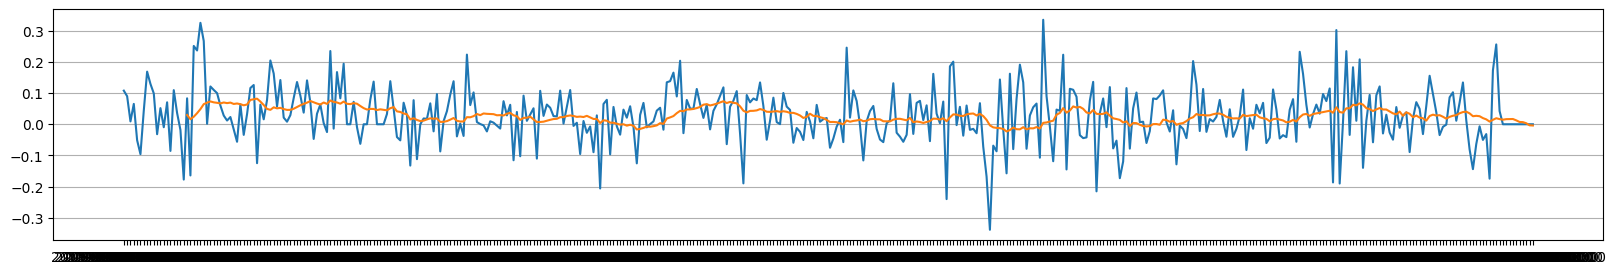

In [15]:
data = pd.read_csv('/mnt/lustre/chenruobing/projects/alphaminer/alphaminer/gpmining/results/rank_ics_1.csv')
print(data.index)
alpha1_data = data.loc[0].T
alpha1_data = alpha1_data.loc[alpha1_data.index[1:-1]]
alpha1_data_smooth = pd.Series(alpha1_data.values).rolling(20).mean()
plt.figure(figsize=(20, 3))
plt.grid(axis='y')
plt.plot(alpha1_data)
plt.plot(alpha1_data_smooth)
plt.title("Alpha {}, Mean ic: {:.2f}".format('alpha_1', alpha1_data.mean()))

RangeIndex(start=0, stop=10, step=1)


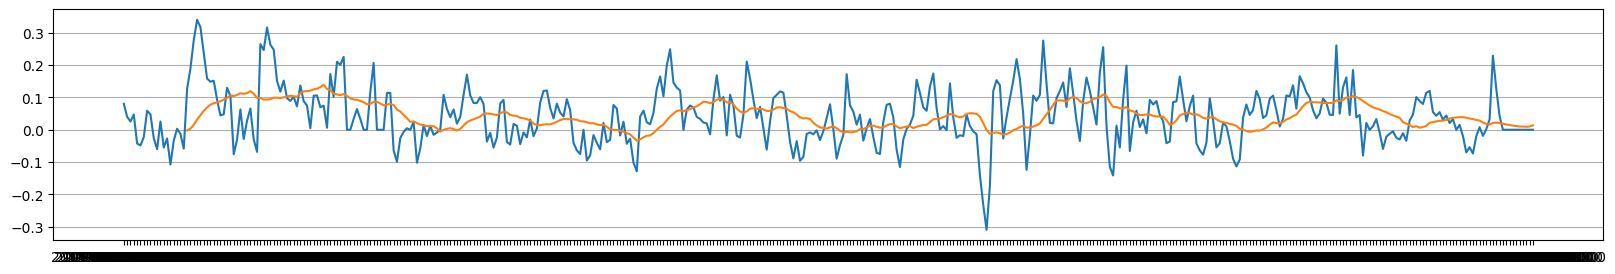

In [16]:
data = pd.read_csv('/mnt/lustre/chenruobing/projects/alphaminer/alphaminer/gpmining/results/rank_ics_5.csv')
print(data.index)
alpha1_data = data.loc[0].T
alpha1_data = alpha1_data.loc[alpha1_data.index[1:-1]]
alpha1_data_smooth = pd.Series(alpha1_data.values).rolling(20).mean()
plt.figure(figsize=(20, 3))
plt.grid(axis='y')
plt.plot(alpha1_data)
plt.plot(alpha1_data_smooth)
plt.title("Alpha {}, Mean ic: {:.2f}".format('alpha_1', alpha1_data.mean()))

RangeIndex(start=0, stop=10, step=1)


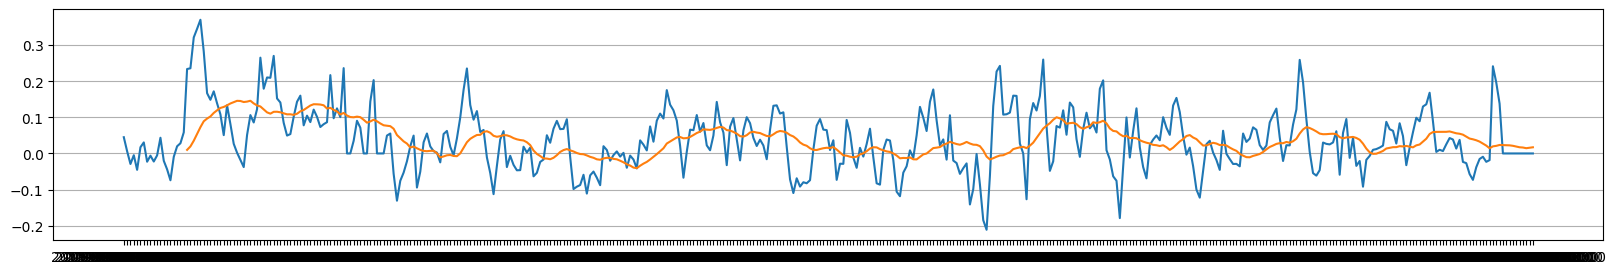

In [17]:
data = pd.read_csv('/mnt/lustre/chenruobing/projects/alphaminer/alphaminer/gpmining/results/rank_ics_10.csv')
print(data.index)
alpha1_data = data.loc[0].T
alpha1_data = alpha1_data.loc[alpha1_data.index[1:-1]]
alpha1_data_smooth = pd.Series(alpha1_data.values).rolling(20).mean()
plt.figure(figsize=(20, 3))
plt.grid(axis='y')
plt.plot(alpha1_data)
plt.plot(alpha1_data_smooth)
plt.title("Alpha {}, Mean ic: {:.2f}".format('alpha_1', alpha1_data.mean()))